In [ ]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

## Data Preparation

In [ ]:
import kagglehub
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import random
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

def load_and_split_images(directory, image_size=(150, 150), test_size=0.2, shuffle=True):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))  # Sorted for consistent labeling

    for class_index, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        image_files = [
            os.path.join(class_path, fname)
            for fname in os.listdir(class_path)
            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]

        for img_path in image_files:
            try:
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(class_index)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=test_size, random_state=42, shuffle=shuffle, stratify=labels
    )

    return (X_train, y_train), (X_test, y_test), class_names

In [ ]:
folder_path = "/content/drive/MyDrive/AI-Food"
(train_images, train_labels), (test_images, test_labels), class_names = load_and_split_images(folder_path)

print(f"Train size: {len(train_images)}, Test size: {len(test_images)}")
print("Classes:", class_names)

Train size: 217, Test size: 55
Classes: ['.ipynb_checkpoints', 'Burger', 'Chicken-Rice', 'Kapao', 'KhaoTomGoong', 'PorkFriedRice', 'Salad', 'Soup', 'Steak', '์Noodles']


In [ ]:
def show_example_images(images, labels, class_names, target_class, num_images=5):
    class_index = class_names.index(target_class)  # Get the index for the target class
    class_images = [images[i] for i in range(len(images)) if labels[i] == class_index]

    # Randomly select a number of images from the filtered class
    selected_images = random.sample(class_images, min(num_images, len(class_images)))

    # Plot the selected images
    plt.figure(figsize=(15, 10))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i+1)

        # Reverse normalization
        img = img * 255.0  # Reverse normalization to show the actual image
        img = img.astype(np.uint8)

        # Plot each image
        plt.imshow(img)
        plt.title(f"Label: {target_class}")
        plt.axis('off')

    plt.show()

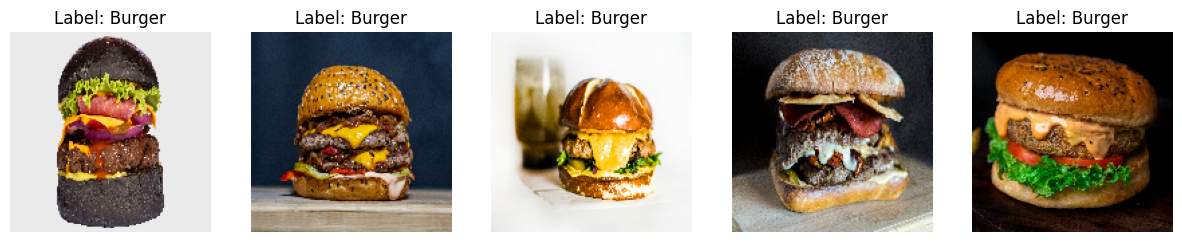

In [ ]:
show_example_images(train_images, train_labels, class_names, target_class="Burger", num_images=5)

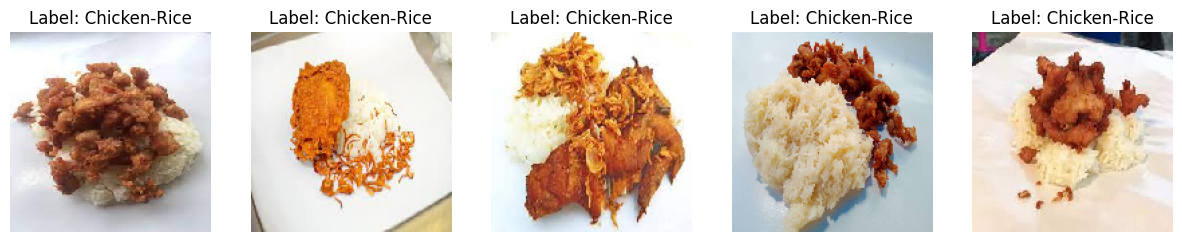

In [ ]:
show_example_images(train_images, train_labels, class_names, target_class="Chicken-Rice", num_images=5)

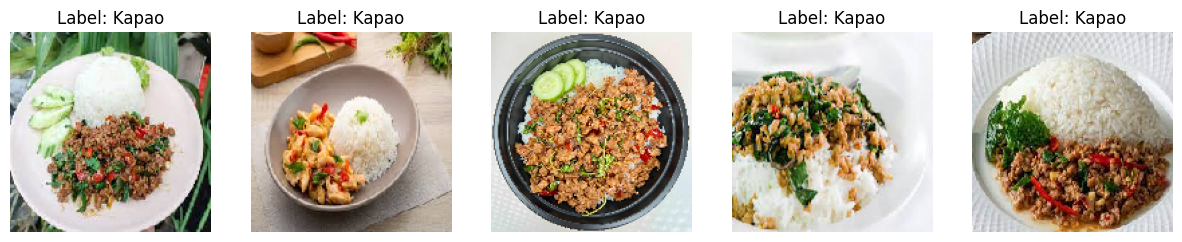

In [ ]:
show_example_images(train_images, train_labels, class_names, target_class="Kapao", num_images=5)

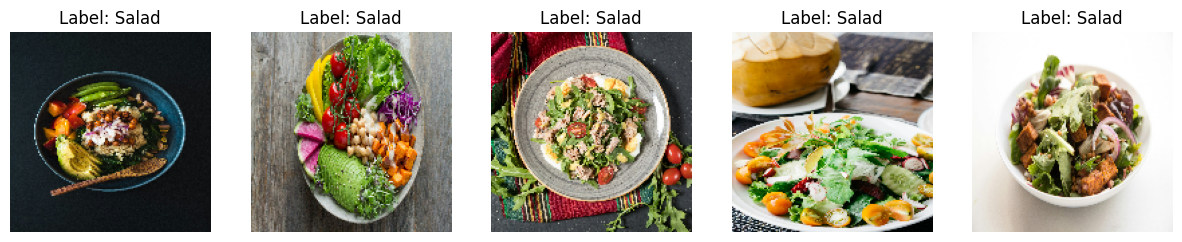

In [ ]:
show_example_images(train_images, train_labels, class_names, target_class="Salad", num_images=5)

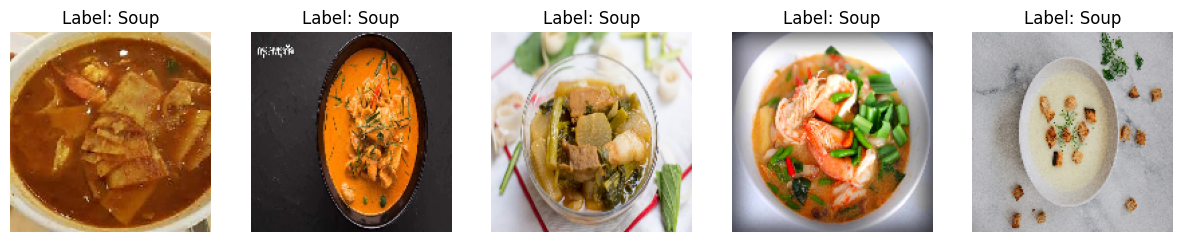

In [ ]:
show_example_images(train_images, train_labels, class_names, target_class="Soup", num_images=5)

## Plot Performance

In [ ]:
def plot_performance(history):
    # Check available keys
    print("Available keys in history.history:", history.history.keys())

    # Use 'accuracy' if available, otherwise fall back to 'acc'
    train_acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history[train_acc_key], label='Train Accuracy')
    plt.plot(history.history[val_acc_key], label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

## Visualize Misclassified Images

In [ ]:
def show_misclassified_images(images, true_labels, pred_labels, class_names, num_images=5):
    misclassified_idx = np.where(true_labels != pred_labels)[0]
    if len(misclassified_idx) == 0:
        print("No misclassified images found.")
        return

    selected_idx = np.random.choice(misclassified_idx, min(num_images, len(misclassified_idx)), replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(selected_idx):
        plt.subplot(1, num_images, i+1)
        img = images[idx] * 255.0  # Reverse normalization
        img = img.astype(np.uint8)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
        plt.axis('off')
    plt.show()


# 1 CNN Model

In [ ]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN
cnn_history = cnn_model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),  # <- fixed this
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
)

Epoch 1/30


KeyboardInterrupt: 

In [ ]:
#Evaluation
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
print(f"Test Accuracy (CNN): {test_acc}")

test_predictions = np.argmax(cnn_model.predict(test_images), axis=1)
print(classification_report(test_labels, test_predictions, target_names=class_names))
show_misclassified_images(test_images, test_labels, test_predictions, class_names)

plot_performance(cnn_history)

In [ ]:
# Experiment : Data Augmentation for CNN
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

cnn_aug_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

cnn_aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train with Augmentation
cnn_aug_history = cnn_aug_model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    validation_data=(test_images, test_labels),
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/30
1/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.1562 - loss: 2.2960

KeyboardInterrupt: 

In [ ]:
# Evaluation
test_loss_aug, test_acc_aug = cnn_aug_model.evaluate(test_images, test_labels)
print(f"Test Accuracy (CNN with Augmentation): {test_acc_aug}")

#Classification Report
cnn_aug_predictions = np.argmax(cnn_aug_model.predict(test_images), axis=1)
print(classification_report(test_labels, cnn_aug_predictions, target_names=class_names))


show_misclassified_images(test_images, test_labels, cnn_aug_predictions, class_names)

plot_performance(cnn_aug_history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 788ms/step - accuracy: 0.1040 - loss: 2.4103
Test Accuracy (CNN with Augmentation): 0.1090909093618393
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step


ValueError: Number of classes, 9, does not match size of target_names, 10. Try specifying the labels parameter

# 2 VGG16 Pretrain Model

In [ ]:
# Pre-trained VGG16 Without Training
from tensorflow.keras.applications import VGG16

# Load VGG16 without top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg_base.trainable = False  # Freeze the base model

# Build Model
vgg_no_train_model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

vgg_no_train_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Extract features (no training, just prediction)
vgg_no_train_model.fit(train_images, train_labels, epochs=1, batch_size=32, verbose=0)  # Dummy fit to build model

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4125 - loss: 1.6934
Test Accuracy (VGG16 No Training): 0.4000000059604645
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


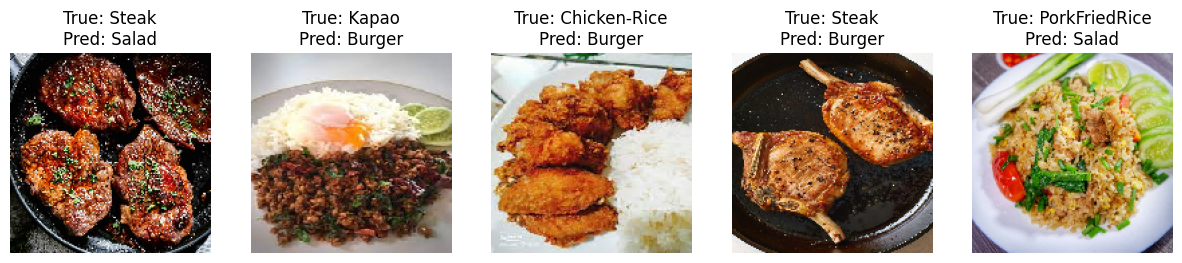

In [ ]:
# Evaluation
test_loss_vgg, test_acc_vgg = vgg_no_train_model.evaluate(test_images, test_labels)
print(f"Test Accuracy (VGG16 No Training): {test_acc_vgg}")

# Classification Report
vgg_no_train_predictions = np.argmax(vgg_no_train_model.predict(test_images), axis=1)
# print(classification_report(test_labels, vgg_no_train_predictions, target_names=class_names))
show_misclassified_images(test_images, test_labels, vgg_no_train_predictions, class_names)


# 3 Pretrain with additional tuning

In [ ]:
# Pre-trained VGG16 with Fine-tuning
vgg_base_tune = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg_base_tune.trainable = True  # Allow fine-tuning

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Update your model
vgg_tune_model = models.Sequential([
    data_augmentation,
    vgg_base_tune,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

vgg_tune_model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Model
vgg_tune_history = vgg_tune_model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
    batch_size=32
)

# Save the model
vgg_tune_model.save('vgg_tune_model.h5')

# Download the model to your local machine
from google.colab import files
files.download('vgg_tune_model.h5')

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.1231 - loss: 2.8869 - val_accuracy: 0.1455 - val_loss: 2.2670
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.1437 - loss: 2.4517 - val_accuracy: 0.1818 - val_loss: 2.1502
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.0995 - loss: 2.4582 - val_accuracy: 0.2182 - val_loss: 2.0689
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.1784 - loss: 2.2850 - val_accuracy: 0.3636 - val_loss: 1.9973
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step - accuracy: 0.1319 - loss: 2.3022 - val_accuracy: 0.3818 - val_loss: 1.9345
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.2219 - loss: 2.1201 - val_accuracy: 0.4182 - val_loss: 1.8764
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.2608 - loss: 2.0491 - val_accuracy: 0.4000 - val_loss: 1.8242
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.3069 - loss: 1.8724 - val_accuracy: 0.5273 - val_loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers import Adam

# Use MobileNetV3 (can switch to MobileNetV3Small if desired)
mobilenet_base = MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)  # MobileNetV3 expects 224x224
)

mobilenet_base.trainable = True  # Fine-tune the base model

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),  # Rescale pixel values
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Model definition
mobilenet_model = models.Sequential([
    data_augmentation,
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resize all training and test images
train_images_resized = tf.image.resize(train_images, [224, 224])
test_images_resized = tf.image.resize(test_images, [224, 224])

# Train the model
mobilenet_history = mobilenet_model.fit(
    train_images_resized, train_labels,
    validation_data=(test_images_resized, test_labels),
    epochs=30,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
)

# Save the model
mobilenet_model.save('mobilenet_v3_model.h5')

# Download (if in Colab)
from google.colab import files
files.download('mobilenet_v3_model.h5')


In [ ]:
# Evaluate on Test Set
from tensorflow.keras.models import load_model
vgg_tune_model = load_model('vgg_tune_model.h5')
# mobilenet_tune_model = load_model('mobilenet_v3_model.h5')
test_loss_tune, test_acc_tune = vgg_tune_model.evaluate(test_images, test_labels)
print(f"Test Accuracy (VGG16 Fine-tuned): {test_acc_tune}")


# Classification Report
vgg_tune_predictions = np.argmax(vgg_tune_model.predict(test_images), axis=1)
print(classification_report(test_labels, vgg_tune_predictions, target_names=class_names))
show_misclassified_images(test_images, test_labels, vgg_tune_predictions, class_names)

# # Classification Report for MobileNetV3
# mobilenet_v3_model_predictions = np.argmax(mobilenet_tune_model.predict(test_images), axis=1)
# print("MobileNetV3 Classification Report")
# print(classification_report(test_labels, mobilenet_v3_model_predictions, target_names=class_names))
# show_misclassified_images(test_images, test_labels, mobilenet_v3_model_predictions, class_names)

# plot_performance(vgg_tune_history)

## Experiment Evaluation & Analysis

In [ ]:
def evaluate_model(model, test_images, test_labels):
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test accuracy: {test_acc:.4f}")
    return test_loss, test_acc

#### CNN vs CNN with Data Augmentation

In [ ]:
evaluate_model(cnn_model, test_images, test_labels)
evaluate_model(cnn_aug_model, test_images, test_labels)


#### CNN vs VGG16

In [ ]:
evaluate_model(cnn_model, test_images, test_labels)
evaluate_model(vgg_no_train_model, test_images, test_labels)

#### VGG16 vs VGG16 with Additional Tuning

In [ ]:
evaluate_model(vgg_no_train_model, test_images, test_labels)
evaluate_model(vgg_tune_model, test_images, test_labels)

## Predict

In [ ]:
def plot_prediction(model, img_path, class_names):
    # Load the image from the given path
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to the same size the model expects
    # Convert the image to a numpy array and preprocess (normalize the pixel values)
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1] for model input
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (model expects [batch_size, height, width, channels])

    # Make the prediction
    predictions = model.predict(img_array)

    # For binary classification, the output is a single value
    if predictions.shape[1] == 1:
        predicted_class = class_names[1] if predictions[0] > 0.5 else class_names[0]  # Sigmoid threshold at 0.5
    else:
        predicted_class = class_names[np.argmax(predictions)]  # For multi-class, use argmax on softmax output

    # Plot the image and display the prediction
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

In [ ]:
img_path ='test_soup_2.jpg'
plot_prediction(vgg_tune_model, img_path, class_names)
# plot_prediction(vgg_no_train_model, img_path, class_names)
# plot_prediction(cnn_model, img_path, class_names)
# plot_prediction(cnn_aug_model, img_path, class_names)
